Neste script temos dois exemplos de modelos para classificação de emoções a patir de áudio que são inicialmente representandos com o espectogramas.

1) um modelo que combina CNN e LSTM. Neste o espectograma é fatiado e trechos são passados na sequência temporal para a CNN que extrai features e alimenta a LSTM que fornece o resultado no final.

2) um modelo baseado em CNN apenas, que recebe o espectograma inteiro e faz a classificação.

Este scrit foi utilizado como ponto de partida para o mestrado de uma aluna do PPGIa (Flávia) que testou diferentes CNNs pré-treinadas como extrator de features e combinou os resultados. Produzindo um artigo no CIARP 2023.



In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Carregando dados...
['03-01-01-01-02-02-08.wav', '03-01-04-02-02-02-08.wav', '03-01-08-02-02-02-07.wav', '03-01-04-01-02-02-08.wav', '03-01-01-01-01-01-08.wav', '03-01-02-01-02-02-08.wav', '03-01-03-02-01-01-08.wav', '03-01-05-02-02-02-08.wav', '03-01-02-02-02-02-08.wav', '03-01-03-02-02-02-08.wav', '03-01-02-01-02-01-08.wav', '03-01-06-02-02-02-08.wav', '03-01-05-01-01-02-08.wav', '03-01-02-01-01-02-08.wav', '03-01-03-01-02-01-08.wav', '03-01-05-02-01-01-08.wav', '03-01-03-02-01-02-08.wav', '03-01-07-01-02-01-08.wav', '03-01-06-01-02-01-08.wav', '03-01-05-01-02-02-08.wav', '03-01-05-02-01-02-08.wav', '03-01-04-01-01-01-08.wav', '03-01-03-01-02-02-08.wav', '03-01-05-01-01-01-08.wav', '03-01-07-01-01-01-08.wav', '03-01-05-02-02-01-08.wav', '03-01-04-02-02-01-08.wav', '03-01-02-02-01-01-08.wav', '03-01-04-01-02-02-09.wav', '03-01-02-01-02-01-09.wav', '03-01-03-01-01-01-09.wav', '03-01-04-01-01-01-09.wav', '03-01-02-02-01-02-09.wav', '03-01-03-02-02-02-09.wav', '03-01-07-02-01-01-08.wav',

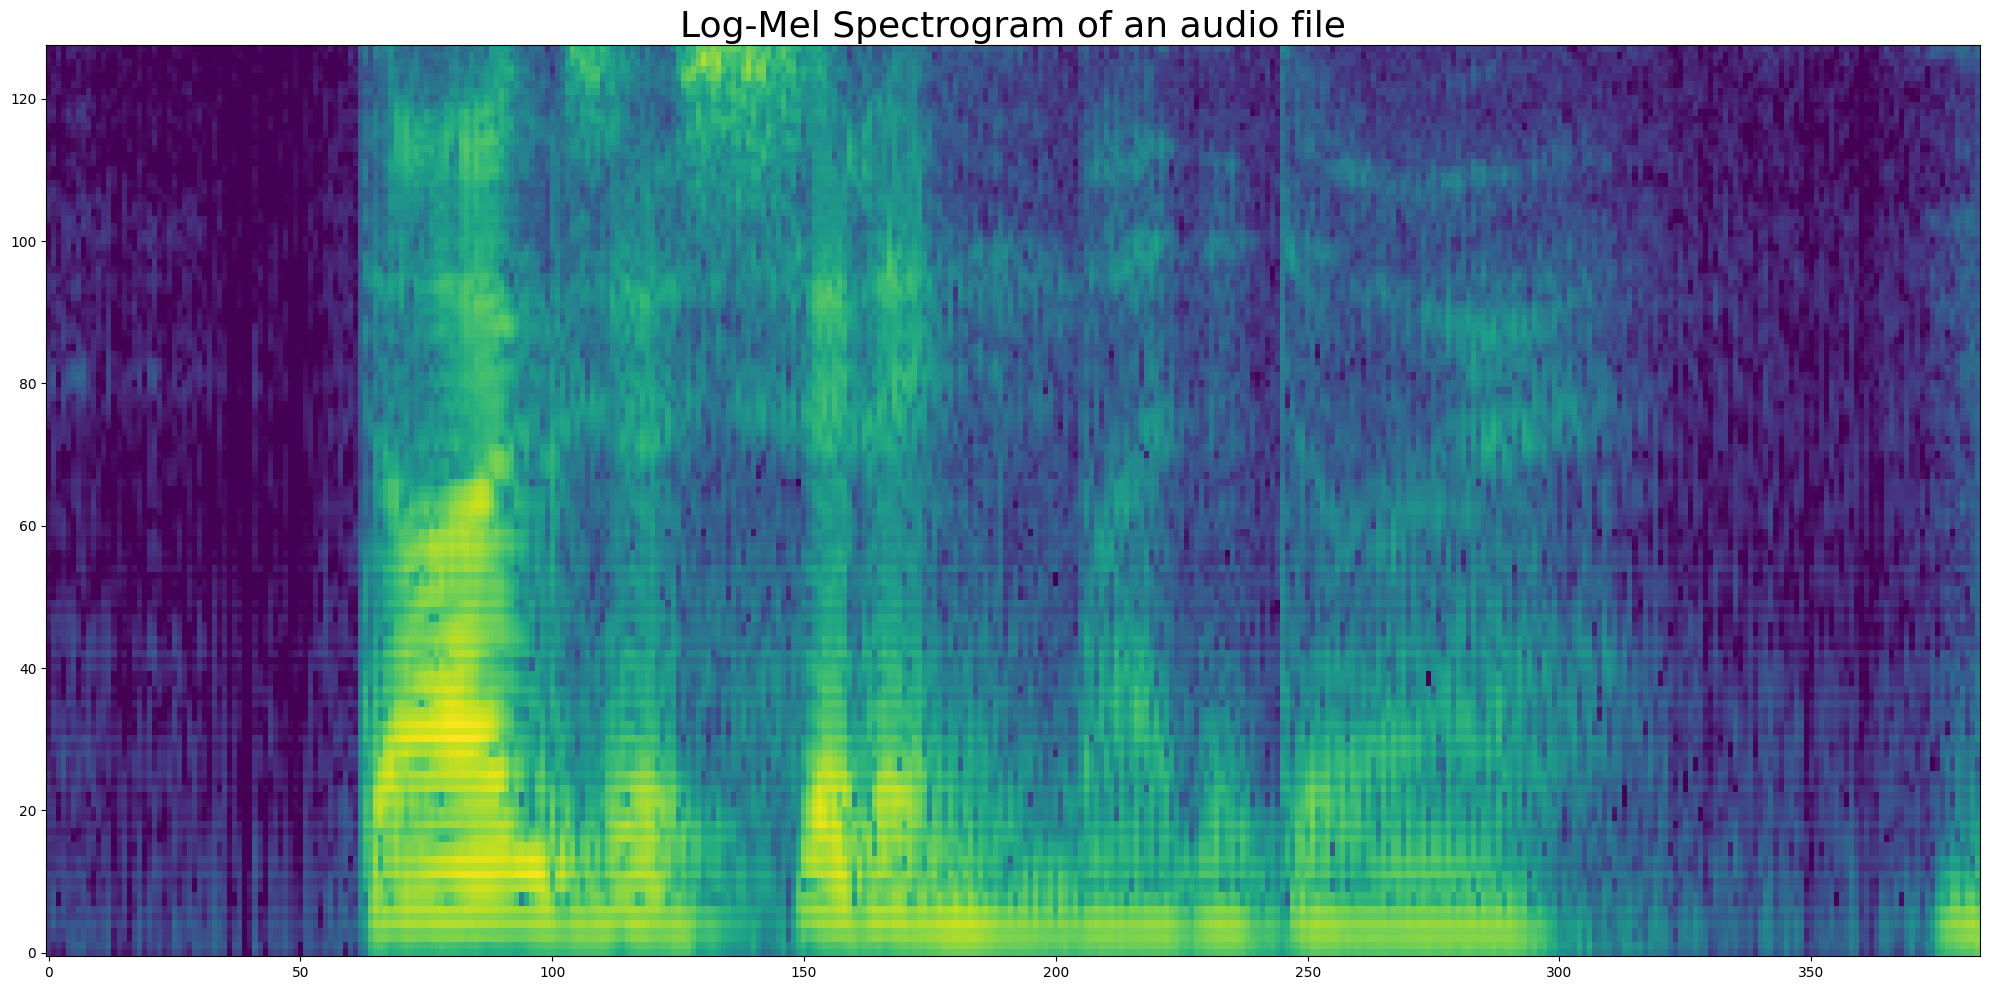

In [ ]:
import os
from glob import glob
import pickle
import itertools
import numpy as np
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
import librosa
import IPython
from IPython.display import Audio

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# RAVDESS Database
label_dict_ravdess = {
    '02': 'Calmo',
    '03':'Feliz',
    '04':'Triste',
    '05':'Raiva',
    '06':'Medo',
    '07':'Desgosto',
    '08':'Surpreso'
}

# Set audio files labels
def set_label_ravdess(audio_file, gender_differentiation):
    label = label_dict_ravdess.get(audio_file[6:-16])
    if gender_differentiation == True:
        if int(audio_file[18:-4])%2 == 0: # Female
            label = 'f_' + label
        if int(audio_file[18:-4])%2 == 1: # Male
            label = 'm_' + label
    return label


# Start feature extraction
print("Carregando dados...")

# Audio file path and names
file_path = '/content/drive/MyDrive/ravdess/'
file_names=os.listdir(file_path)
print(file_names)

# Initialize features and labels list
signal = []
labels = []

# Sample rate (16.0 kHz)
sample_rate = 16000

# Max pad lenght (3.0 sec)
max_pad_len = 49100

# Compute spectogram for all audio file
for audio_index, audio_file in enumerate(file_names):

    if audio_file[6:-16] in list(label_dict_ravdess.keys()):

        # Read audio file
        y, sr = librosa.core.load(file_path + audio_file, sr=sample_rate, offset=0.5)

        # Z-normalization
        y = zscore(y)

        # Padding or truncated signal
        if len(y) < max_pad_len:
            y_padded = np.zeros(max_pad_len)
            y_padded[:len(y)] = y
            y = y_padded
        elif len(y) > max_pad_len:
            y = np.asarray(y[:max_pad_len])

        # Add to signal list
        signal.append(y)

        # Set label
        labels.append(set_label_ravdess(audio_file, False))

        # Print running...
        if (audio_index % 100 == 0):
            print("{} arquivos carregados".format(audio_index))


labels = np.asarray(labels).ravel()

print("Todos os arquivos foram carregados \n")
print("Total de arquivos: {}".format(labels.shape[0]))

# Number of augmented data
nb_augmented = 2

# Adiciona um ruido no sinal de Ã¡udio
def noisy_signal(signal, snr_low=15, snr_high=30, nb_augmented=2):
    # Tamanho do sinal
    signal_len = len(signal)

    noise = np.random.normal(size=(nb_augmented, signal_len))

    # Compute signal and noise power
    s_power = np.sum((signal / (2.0 ** 15)) ** 2) / signal_len
    n_power = np.sum((noise / (2.0 ** 15)) ** 2, axis=1) / signal_len

    # SNR: Uniform [15, 30]
    snr = np.random.randint(snr_low, snr_high)

    K = np.sqrt((s_power / n_power) * 10 ** (- snr / 10))
    K = np.ones((signal_len, nb_augmented)) * K

    return signal + K.T * noise

augmented_signal = list(map(noisy_signal, signal))

def mel_spectrogram(y, sr=16000, n_fft=512, win_length=256, hop_length=128, window='hamming', n_mels=128, fmax=4000):
    mel_spect = np.abs(librosa.stft(y, n_fft=n_fft, window=window, win_length=win_length, hop_length=hop_length)) ** 2

    mel_spect = librosa.feature.melspectrogram(S=mel_spect, sr=sr, n_mels=n_mels, fmax=fmax)

    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)

    return mel_spect


# Gera o espectograma de todos os sinais de Ã¡udio
mel_spect = np.asarray(list(map(mel_spectrogram, signal)))
augmented_mel_spect = [np.asarray(list(map(mel_spectrogram, augmented_signal[i]))) for i in range(len(augmented_signal))]


# Plot one random Spectogram
plt.figure(figsize=(20, 10))
plt.imshow(mel_spect[np.random.randint(len(mel_spect))], origin='lower', aspect='auto', cmap='viridis')
plt.title('Log-Mel Spectrogram of an audio file', fontsize=26)
plt.tight_layout()
plt.show()


# Build Train and test dataset
MEL_SPECT_train, MEL_SPECT_test, AUG_MEL_SPECT_train, AUG_MEL_SPECT_test, label_train, label_test = train_test_split(mel_spect, augmented_mel_spect, labels, test_size=0.2)

# Build augmented labels and train
aug_label_train = np.asarray(list(itertools.chain.from_iterable([[label] * nb_augmented for label in label_train])))
AUG_MEL_SPECT_train = np.asarray(list(itertools.chain.from_iterable(AUG_MEL_SPECT_train)))

# Concatenate original and augmented
X_train = np.concatenate((MEL_SPECT_train, AUG_MEL_SPECT_train))
y_train = np.concatenate((label_train, aug_label_train))

# Build test set
X_test = MEL_SPECT_test
y_test = label_test

# Salve os espectogramas inteiros (um para cada áudio)
np.save('X_train_a.npy', X_train)
np.save('X_test_a.npy', X_test)
np.save('y_train_a.npy', y_train)
np.save('y_test_a.npy', y_test)

# Delete
del MEL_SPECT_train, AUG_MEL_SPECT_train, label_train, aug_label_train, AUG_MEL_SPECT_test, MEL_SPECT_test, label_test
del mel_spect, augmented_mel_spect, labels

# Time distributed parameters
win_ts = 128
hop_ts = 64


# Split spectrogram into frames para a LSTM
def frame(x, win_step=128, win_size=64):
    nb_frames = 1 + int((x.shape[2] - win_size) / win_step)
    frames = np.zeros((x.shape[0], nb_frames, x.shape[1], win_size)).astype(np.float32)
    for t in range(nb_frames):
        frames[:,t,:,:] = np.copy(x[:,:,(t * win_step):(t * win_step + win_size)]).astype(np.float32)
    return frames



# Frame for TimeDistributed model
X_train = frame(X_train, hop_ts, win_ts)
X_test = frame(X_test, hop_ts, win_ts)

pickle.dump(X_train.astype(np.float16), open('X_train.p', 'wb'))
pickle.dump(y_train, open('y_train.p', 'wb'))
pickle.dump(X_test.astype(np.float16), open('X_test.p', 'wb'))
pickle.dump(y_test, open('y_test.p', 'wb'))

In [ ]:


print(X_train.shape)

nb_frames = 1 + int((X_train.shape[2] - 128) / 64)
print(nb_frames)
for t in range(nb_frames):
  print(t)

(3225, 5, 128, 128)
1
0


In [ ]:
# Treinamento de Modelo CNN + LSTM => usando espectograma dividido em frames verticais
import pickle
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, TimeDistributed, concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
#from tensorflow.utils import np_utils
from tensorflow.keras import utils
#from keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

X_train = pickle.load(open('X_train.p', 'rb'))
y_train = pickle.load(open('y_train.p', 'rb'))
y_test = pickle.load(open('y_test.p', 'rb'))
X_test = pickle.load(open('X_test.p', 'rb'))

print(X_train.shape)
print(X_test.shape)

# Encode label
# Encode Label from categorical to numerical
lb = LabelEncoder()
y_train = utils.to_categorical(lb.fit_transform(np.ravel(y_train)))
y_test = utils.to_categorical(lb.transform(np.ravel(y_test)))

# Reshape train and test set
# Reshape for convolution
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , X_train.shape[2], X_train.shape[3], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , X_test.shape[2], X_test.shape[3], 1)

K.clear_session()

# Modelo combinando CNN + LSTM

input_shape = Input(shape=X_train.shape[1:])
print(input_shape)

x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'))(input_shape)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(Activation('elu'))(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))(x)
x = TimeDistributed(Dropout(0.2))(x)

x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(Activation('elu'))(x)
x = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))(x)
x = TimeDistributed(Dropout(0.2))(x)

x = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(Activation('elu'))(x)
x = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))(x)
x = TimeDistributed(Dropout(0.2))(x)

x = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(Activation('elu'))(x)
x = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))(x)
x = TimeDistributed(Dropout(0.2))(x)

x = TimeDistributed(Flatten())(x)

x = LSTM(256, return_sequences=False, dropout=0.2)(x)

x = Dense(7, activation='softmax')(x)

model = Model(inputs=input_shape, outputs=x)

# Compile model
model.compile(optimizer=SGD(lr=0.01, momentum=0.8), loss='categorical_crossentropy', metrics=['accuracy'])

# Save best model
best_model_save = ModelCheckpoint('./best_model', save_best_only=True, monitor='val_accuracy', mode='max')

# Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, verbose=1, mode='max')

# Fit model
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_split=0.2, callbacks=[early_stopping, best_model_save])

# Save model
model.save('/content/drive/My Drive/CNN-LSTM-model.h5')
model.save_weights('/content/drive/My Drive/CNN-LSTM-weights.h5')

(3225, 5, 128, 128)
(269, 5, 128, 128)
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 128, 128, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


Epoch 1/100
41/41 [==============================] - 43s 759ms/step - loss: 1.9620 - accuracy: 0.1562 - val_loss: 2.0696 - val_accuracy: 0.1178
Epoch 2/100
41/41 [==============================] - 20s 478ms/step - loss: 1.8939 - accuracy: 0.2047 - val_loss: 2.2814 - val_accuracy: 0.1178
Epoch 3/100
41/41 [==============================] - 27s 658ms/step - loss: 1.8204 - accuracy: 0.2484 - val_loss: 1.9641 - val_accuracy: 0.2574
Epoch 4/100
41/41 [==============================] - 18s 446ms/step - loss: 1.7391 - accuracy: 0.2946 - val_loss: 1.8080 - val_accuracy: 0.2543
Epoch 5/100
41/41 [==============================] - 18s 447ms/step - loss: 1.6749 - accuracy: 0.3345 - val_loss: 1.9359 - val_accuracy: 0.2388
Epoch 6/100
41/41 [==============================] - 18s 449ms/step - loss: 1.6365 - accuracy: 0.3554 - val_loss: 1.9626 - val_accuracy: 0.2357
Epoch 7/100
41/41 [==============================] - 27s 665ms/step - loss: 1.5997 - accuracy: 0.3547 - val_loss: 1.8628 - val_accuracy:

In [ ]:
# MOdel evaluate
# evaluate model

model.load_weights("./best_model")
_, acc = model.evaluate(X_test, y_test, verbose=0)
print('Final Accuracy: > %.3f' % (acc * 100.0))

ypred=model.predict(X_test)
acc=0
for i in range(0, len(ypred)):
  label=np.argmax(y_test[i])
  first=np.argmax(ypred[i])
  ypred[i][first]=0
  second=np.argmax(ypred[i])
  ypred[i][second]=0
  third=np.argmax(ypred[i])
  if first==label or second==label or third==label:
    acc=acc+1
print('Taxa:', acc/len(ypred))

Final Accuracy: > 67.658
9/9 [==============================] - 1s 54ms/step
Taxa: 0.9107806691449815


In [ ]:
# Treinamento de CNN => usando espectograma inteiro
# modelo treinado do zero

import os
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import keras
import sys

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

X_train=np.load('X_train_a.npy')
X_test=np.load('X_test_a.npy')
y_train=np.load('y_train_a.npy')
y_test=np.load('y_test_a.npy')

lb = LabelEncoder()
y_train = utils.to_categorical(lb.fit_transform(np.ravel(y_train)))
y_test = utils.to_categorical(lb.transform(np.ravel(y_test)))

print(X_train.shape)
print(X_test.shape)
print(y_train)

X_train=X_train.reshape((X_train.shape[0], 128, 384, 1))
X_test=X_test.reshape((X_test.shape[0], 128, 384, 1))

input_shape=X_train[0].shape

weight_decay=1e-4
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(16, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense((1024), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense((512), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(7, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

results = model.fit(X_train, y_train,
          batch_size=16,
          epochs=20,
          verbose=1,
          validation_split=0.2)

_, acc = model.evaluate(X_test, y_test, verbose=0)
print('Teste > %.3f' % (acc * 100.0))


(3225, 128, 384)
(269, 128, 384)
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 384, 16)      160       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 64, 192, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_4 (Bat  (None, 64, 192, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 192, 16)       2320      
                                                                 

In [ ]:
import numpy as np

ypred=model.predict(X_test)
print(ypred[0])
print(y_test[0])

acc=0
for i in range(0, len(ypred)):
  label=np.argmax(y_test[i])
  first=np.argmax(ypred[i])
  ypred[i][first]=0
  second=np.argmax(ypred[i])
  ypred[i][second]=0
  third=np.argmax(ypred[i])
  if first==label or second==label or third==label:
    acc=acc+1
print('Taxa:', acc/len(ypred))


NameError: name 'model' is not defined